导入所需要的库

In [1]:
import torch.nn as nn
import cv2
import torch
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import sys
import os
from tqdm import tqdm
from torchsummary import summary

D:\anaconda\envs\PyTorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


调用GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


载入根路径

In [3]:
data_root = os.path.abspath(os.path.join(os.getcwd(), "C:/Users/liuyang/Desktop/000")) 
image_path = os.path.join(data_root, "flower_data") 

使用 OpenCV 加载其中一张图像，并将其从 BGR（蓝绿红）颜色空间转换为 RGB（红绿蓝）颜色空间。

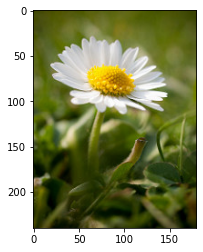

In [4]:
img_BGR = cv2.imread('C:/Users/liuyang/Desktop/000/flower_data/001.jpg',1)
img1 = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)  # 将BGR颜色空间转换为RGB颜色空间
plt.imshow(img1)

对训练数据归一化并进行了水平翻转，扩充训练数据集的规模和多样性

In [5]:
data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
         "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [6]:
batch_size = 32
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=0)

validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=4, shuffle=False,
                                                  num_workers=0)

In [7]:
train_num = len(train_dataset)
print(train_num)

3306


In [8]:
val_num = len(validate_dataset)
print(val_num)

364


搭建VGG网络

In [9]:
class VGG(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(512*7*7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
    
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [10]:
model = VGG(num_classes=5).to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [13]:
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

设置模型训练模式并训练模型

In [12]:
    net = VGG(num_classes=5, init_weights=True)

    net.to(device)
    loss_function = nn.CrossEntropyLoss()
    # pata = list(net.parameters())
    optimizer = optim.Adam(net.parameters(), lr=0.0002)

    epochs = 5
    save_path = './VGG.pth'
    best_acc = 0.0
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:04<00:00, 22.13it/s]
[epoch 1] train_loss: 1.450  val_accuracy: 0.374
100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 22.83it/s]
[epoch 2] train_loss: 1.261  val_accuracy: 0.519
100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 23.02it/s]
[epoch 3] train_loss: 1.161  val_accuracy: 0.536
100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 23.03it/s]
[epoch 4] train_loss: 1.095  val_accuracy: 0.560
100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 23.09it/s]
[epoch 5] train_loss: 1.040  val_accuracy: 0.629
Finished Training


使用 OpenCV 加载要预测的图像

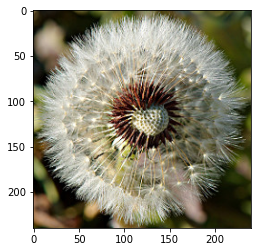

In [15]:
from PIL import Image   
img_path = "C:/Users/liuyang/Desktop/000/flower_data/002.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)
plt.imshow(img)

图片预处理

In [16]:
data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
img = data_transform(img)
img = torch.unsqueeze(img, dim=0)
model = VGG(num_classes=5).to(device)
weights_path = "./VGG.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path))


<All keys matched successfully>

In [17]:
with torch.no_grad():
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

应用模型预测

In [18]:
print(predict_cla)

1


In [19]:
label = ['daisy','dandelion','roses','sunflowers','tulips']
print(label[predict_cla])

dandelion
